In [39]:
import cv2
import glob
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.normalization import BatchNormalization

from keras.optimizers import Adam
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from utils import get_pre_processed_image


%matplotlib inline

In [40]:
SIMULATOR_HOME = "/Users/ddigges/simulator/data/"
DRIVING_LOG_FILE = "driving_log.csv"
DRIVING_LOG_FILE_PATH = os.path.join(SIMULATOR_HOME, DRIVING_LOG_FILE)

IMG = "IMG"
IMAGE_PATH = os.path.join(os.path.join(SIMULATOR_HOME, IMG))

n = len(glob.glob(os.path.join(IMAGE_PATH, "*"))) * 3
batch_size = 128
samples_per_epoch = int(n/batch_size)
nb_epoch = 10
#steering_offset = 0.28
steering_offset = 0.31
num_channels = 3

In [41]:
driving_log = pd.read_csv(DRIVING_LOG_FILE_PATH)

In [42]:
driving_log.columns = ["center", "left", "right", "steering", "throttle", "brake", "speed"]

In [43]:
driving_log.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [59]:
center = driving_log[["center", "steering"]]
center.columns = ["image", "angle"]

left = driving_log[["left", "steering"]]
left.steering += steering_offset
left.columns = ["image", "angle"]

right = driving_log[["right", "steering"]]
right.steering -= steering_offset
right.columns = ["image", "angle"]


all_data = pd.concat([center, left, right])

all_data.shape

/Users/ddigges/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


(24108, 2)

In [60]:
image = cv2.cvtColor(plt.imread(os.path.join(SIMULATOR_HOME, driving_log[:1]['center'][0])), cv2.COLOR_BGR2YUV)

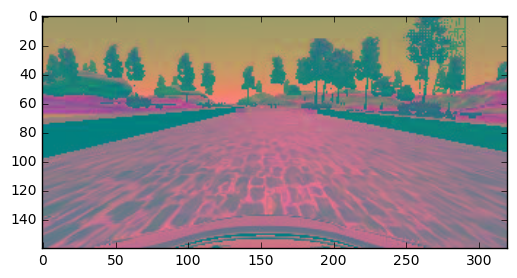

In [61]:
plt.imshow(image)

In [62]:
rows_to_crop_top = int(image.shape[0] * 0.3)
rows_to_crop_bottom = int(image.shape[0] * 0.1)

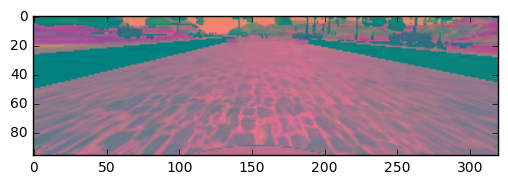

In [63]:
image = image[rows_to_crop_top:image.shape[0] - rows_to_crop_bottom, :, :]
plt.imshow(image)

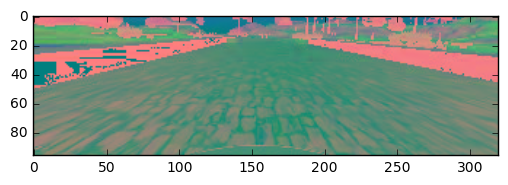

In [64]:
row,col,ch= image.shape
mean = 0
sigma = 0.0000001
gauss = np.random.normal(mean,sigma,(row,col,ch))
noisy = image + gauss
plt.imshow(noisy)

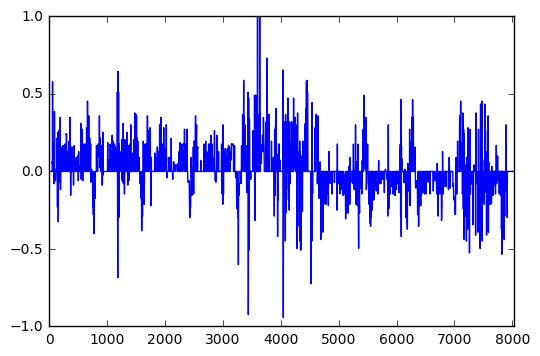

In [65]:
driving_log.steering.plot.line();

In [66]:
def read_image(file_name):
    return plt.imread(file_name)

In [67]:
val = driving_log[:1]['center']

In [68]:
image = read_image(os.path.join(SIMULATOR_HOME, val.values[0]))

In [69]:
# IMAGE: 160 x 320 with 3 color channels
image.shape

(160, 320, 3)

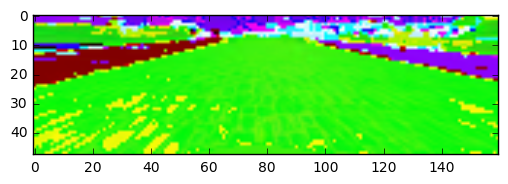

In [70]:
image = plt.imread(os.path.join(SIMULATOR_HOME, driving_log[:200]['center'][0]))
image = get_pre_processed_image(image, num_channels)
plt.imshow(image)

In [71]:
for i, row in driving_log[:3].iterrows():
    print(row['center'], row['steering'])

IMG/center_2016_12_01_13_30_48_287.jpg 0.0
IMG/center_2016_12_01_13_30_48_404.jpg 0.0
IMG/center_2016_12_01_13_31_12_937.jpg 0.0


In [72]:
# shuffle
driving_log = driving_log.sample(frac=1).reset_index(drop=True)

In [73]:
driving_log.shape

(8036, 7)

In [83]:
def data_generator(df, batch_size=128):
    n_rows = df.shape[0]
    while True:
        # Shuffle the data frame rpws after every complete cycle through the data
        df = df.sample(frac=1).reset_index(drop=True)
        
        for index in range(0, n_rows, batch_size):
            df_batch = df[index: index + batch_size]

            # Ignoring the last batch which is smaller than the requested batch size
            if(df_batch.shape[0] == batch_size):
                
                X_batch = np.array([get_pre_processed_image(mpimg.imread(os.path.join(SIMULATOR_HOME, row["image"].strip())), num_channels) for i, row in df_batch.iterrows()])
                y_batch = np.array([row['angle'] for i, row in df_batch.iterrows()])
                yield X_batch, y_batch


In [84]:
gen = data_generator(all_data)

In [85]:
X_batch, y_batch = next(gen)

In [86]:
X_batch.shape

(128, 48, 160, 3)

In [87]:
y_batch.shape

(128,)

(array([  3.,   7.,  29.,   8.,   3.,  34.,  10.,  25.,   5.,   4.]),
 array([-0.5406556, -0.4341044, -0.3275532, -0.221002 , -0.1144508,
        -0.0078996,  0.0986516,  0.2052028,  0.311754 ,  0.4183052,
         0.5248564]),
 <a list of 10 Patch objects>)

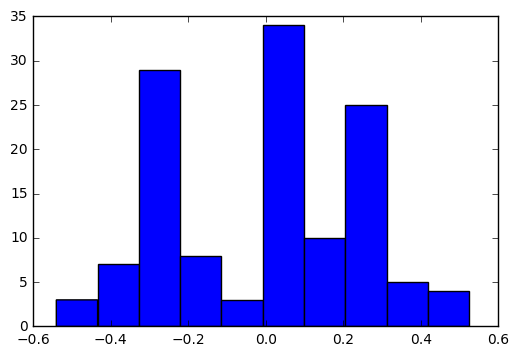

In [88]:
plt.hist(y_batch)

In [91]:
gen = data_generator(all_data)

x,y = next(gen)
x.shape

gen = data_generator(all_data)
print(x.shape)
print(num_channels
     )

(128, 48, 160, 3)
3


In [92]:
model = Sequential()

#model.add(BatchNormalization(input_shape=(x.shape[1], x.shape[2], num_channels)))
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="same", input_shape=(x.shape[1], x.shape[2], x.shape[3])))
model.add(ELU())
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="same"))
model.add(Flatten())
model.add(Dropout(.5))
model.add(ELU())
model.add(Dense(100))
model.add(Dropout(.5))
model.add(ELU())
model.add(Dense(50))
model.add(Dropout(.5))
model.add(ELU())
model.add(Dense(1))

adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss="mse")


In [93]:
model.fit_generator(gen, samples_per_epoch*batch_size, nb_epoch=1)

Epoch 1/1
72320/72320 [==============================] - 602s - loss: 0.0511   


In [30]:
model.save_weights("model.h5")

In [31]:
file = open("model.json", "w")
file.write(model.to_json())
file.close()